In [219]:
import sys
import logging
import concurrent.futures
import time
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import icesat2
from sliderule import sliderule
import geojson
from scipy.interpolate import griddata
from scipy.fft import fft, rfft, fftfreq
from scipy.signal import blackman
import rasterio
from rasterio.plot import show
import scipy.integrate as integrate

In [2]:
# Configure ICESat-2 API
icesat2.init("icesat2sliderule.org", verbose=False, max_resources = 1000)

In [3]:
# Specify region of interest from geojson
poly_fn = '/home/acdealy/notebooks/ice-shelf-roughness/conger.geojson'
region = icesat2.toregion(poly_fn)

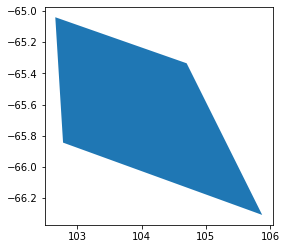

In [4]:
# plot the region to make sure it was read properly
test_region = gpd.read_file(poly_fn)
test_region.plot();

In [183]:
#define parameters for sliderule request
parms = {
    "poly": region[0],
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 20.0, #10.0
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 6, #1
    "t0": '2020-01-01T00:00:00Z',
    "t1": '2022-04-01T00:00:00Z'
}

In [185]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(atl06_sr.shape[0]))

Completed in 107.395 seconds of wall-clock time
Reference Ground Tracks: [ 110  171  232  316  438  491  552  613  674  735  758  880  941  994
 1055 1116 1200 1261 1322   49  377  819 1383 1177]
Cycles: [ 6  7  8  9 10 11 12]
Received 1253173 elevations


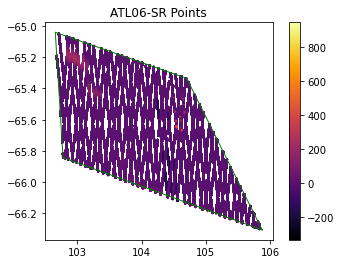

In [14]:
# plot elevation using geodataframe plot method
region_lon = [e["lon"] for e in region[0]]
region_lat = [e["lat"] for e in region[0]]
f, ax = plt.subplots()
ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='inferno', s=1,legend=True)
ax.plot(region_lon, region_lat, linewidth=1, color='g');

554 days 10:03:40.804837824


/tmp/ipykernel_2655923/3501156246.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(points)


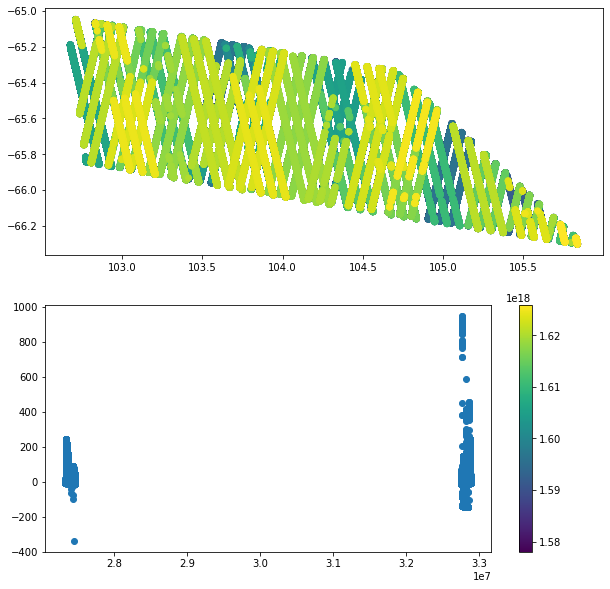

In [15]:
# subset atl06 data before a particular date
#atl06_subset = atl06_sr[(atl06_sr.index > datetime(2018,11,1)) & (atl06_sr.index < datetime(2018,12,1) )]
atl06_subset = atl06_sr[(atl06_sr.index > datetime(2000,1,1)) & (atl06_sr.index < datetime(2023,1,1) )]

# report time range for subset of data
dt = atl06_subset.index[-1] - atl06_subset.index[0]
print(dt)

# plot track points with time as colorscale using matplotlib
fig,ax = plt.subplots(2,1,figsize=(10,10))
points = ax[0].scatter(atl06_subset['geometry'].x,atl06_subset['geometry'].y,c=atl06_subset.index)
plt.colorbar(points)

# plot elevation across this track
ax[1].scatter(atl06_subset["distance"],atl06_subset["h_mean"])
plt.show()

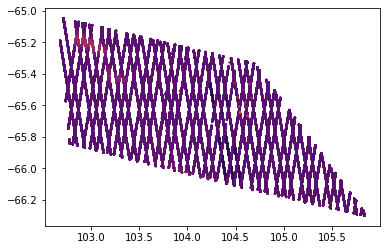

In [16]:
# make our own plot of the elevation data
fig,ax = plt.subplots()
ax.scatter(atl06_sr["geometry"].x,atl06_sr['geometry'].y,c=atl06_sr["h_mean"],cmap='inferno', s=1)
plt.show()

In [17]:
# make new grid
x = np.linspace(np.min(atl06_sr["geometry"].x),np.max(atl06_sr["geometry"].x),100)
y = np.linspace(np.min(atl06_sr["geometry"].y),np.max(atl06_sr["geometry"].y),100)

# fix the grids
grid_x = np.zeros((len(y),len(x)))
for i in range(len(y)):
    grid_x[i,:] = x
grid_y = np.zeros((len(y),len(x)))
for i in range(len(x)):
    grid_y[:,i] = y
    
# get data subset
x_data = atl06_sr["geometry"].x[0:-1:100]
y_data = atl06_sr['geometry'].y[0:-1:100]
elevation = atl06_sr["h_mean"][0:-1:100]

# carry out interpolation
elevation_interp = griddata((x_data,y_data),elevation,(grid_x,grid_y),method='nearest')

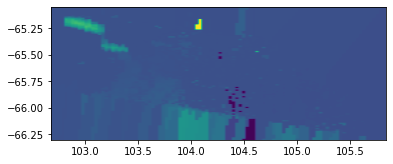

In [18]:
# plot the interpolated data
extent = (np.min(atl06_sr["geometry"].x),np.max(atl06_sr["geometry"].x),np.min(atl06_sr["geometry"].y),np.max(atl06_sr["geometry"].y))
plt.imshow(elevation_interp,origin="lower",extent=extent)

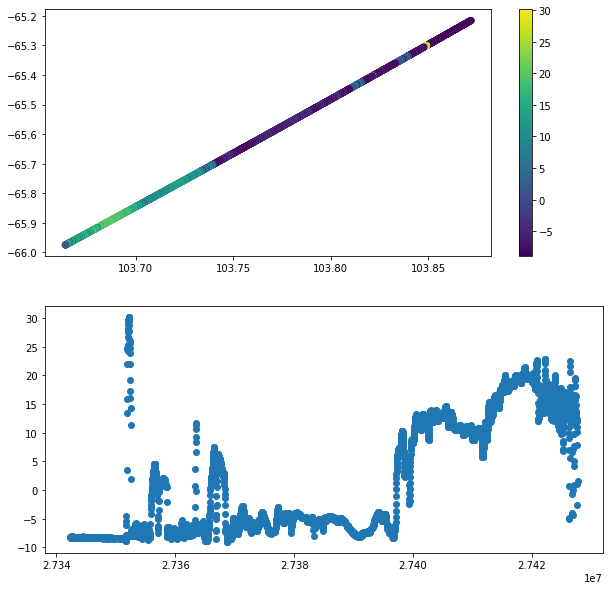

In [132]:
#Accesses a reference ground track with a certain beam on a certain date
atl06_subset6 = atl06_sr[(atl06_sr["rgt"]==1116)&(atl06_sr.index.date==datetime.date(2021, 6, 5))&(atl06_sr.spot==6)]
# np.unique(atl06_line.index.date)

#plot the elevation data
fig,ax = plt.subplots(2,1,figsize=(10,10))
points = ax[0].scatter(atl06_subset6['geometry'].x,atl06_subset6['geometry'].y,c=atl06_subset6.h_mean)
ax[1].scatter(atl06_subset6['distance'],atl06_subset6['h_mean'])
plt.colorbar(points,ax=ax[0])
plt.show()

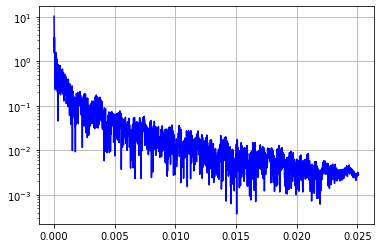

In [281]:
#perform fourier transform
#atl06_subset6['distance'],atl06_subset6['h_mean']
yf = fft(atl06_subset6['h_mean'].values)

#estimate uniform sample size
diffs = np.diff(atl06_subset6['distance'].values)
sample_space = np.mean(diffs)
n = len(atl06_subset6['distance'].values)

#get vector of frequencies
xf = fftfreq(n, sample_space)[:n//2]

#plot 1/2 of transform
plt.semilogy(xf[1:n//2], 2.0/n * np.abs(yf[1:n//2]), '-b')
plt.grid()
plt.show()

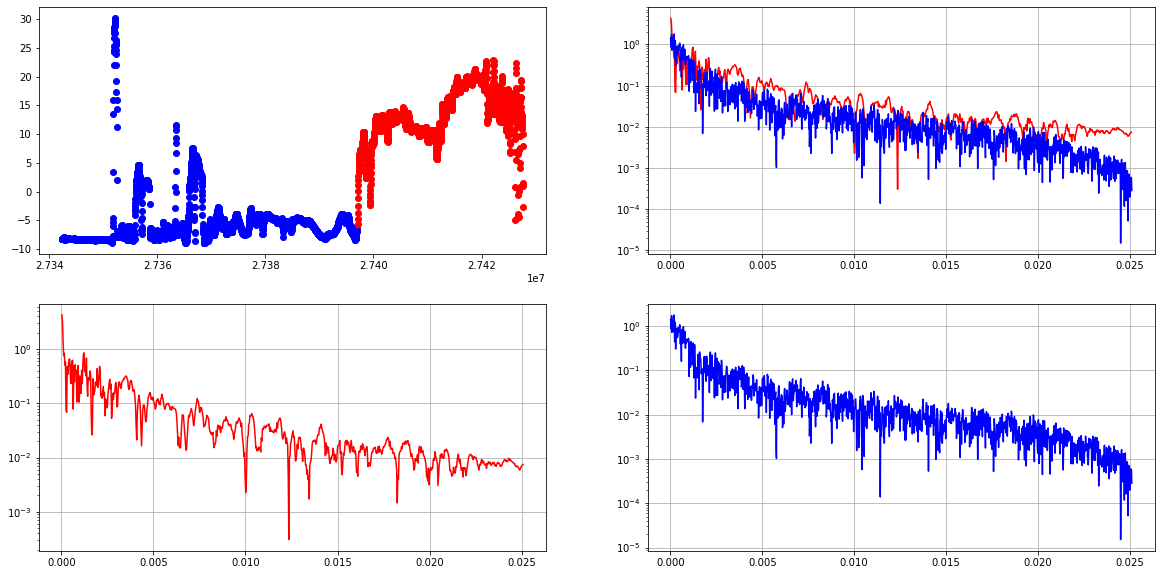

In [283]:
# make a plot to choose shelf/sea ice split point
split_idx = 2740
shelf_h = atl06_subset6['h_mean'][split_idx:len(atl06_subset6['h_mean'])]
shelf_d = atl06_subset6['distance'][split_idx:len(atl06_subset6['h_mean'])]
sea_ice_h = atl06_subset6['h_mean'][0:split_idx]
sea_ice_d = atl06_subset6['distance'][0:split_idx]

#fft for ice shelf
yf_shelf = rfft(shelf_h.values)
diffs_shelf = np.diff(shelf_d.values)
sample_space_shelf = np.mean(diffs_shelf)
n_shelf = len(shelf_d.values)
xf_shelf = fftfreq(n_shelf, sample_space_shelf)[:n_shelf//2]

# get psd (power spectral density) for shelf
power_shelf = np.square(abs(yf_shelf[:n_shelf//2]))
psd_shelf = power_shelf/(xf_shelf[1]-xf_shelf[0])

#fft for sea ice
yf_sea_ice = rfft(sea_ice_h.values)
diffs_sea_ice = np.diff(sea_ice_d.values)
sample_space_sea_ice = np.mean(diffs_sea_ice)
n_sea_ice = len(sea_ice_d.values)
xf_sea_ice = fftfreq(n_sea_ice, sample_space_sea_ice)[:n_sea_ice//2]

# get psd (power spectral density) for sea ice
power_sea_ice = np.square(abs(yf_sea_ice[:n_sea_ice//2]))
psd_sea_ice = power_sea_ice/(xf_sea_ice[1]-xf_sea_ice[0])

#plot sea ice and shelf profiles and transforms with corresponding colors
fig,ax = plt.subplots(2,2,figsize=(20,10))

ax[0][0].scatter(shelf_d,shelf_h,c = 'r')
ax[0][0].scatter(sea_ice_d,sea_ice_h,c = 'b')

ax[1][0].semilogy(xf_shelf[1:n_shelf//2], 2.0/n_shelf * np.abs(yf_shelf[1:n_shelf//2]), '-r')
#ax[1][0].semilogy(xf_shelf[:n_shelf//2], psd_shelf, '-r')
ax[1][0].grid()

ax[1][1].semilogy(xf_sea_ice[1:n_sea_ice//2], 2.0/n_sea_ice * np.abs(yf_sea_ice[1:n_sea_ice//2]), '-b')
#ax[1][1].semilogy(xf_sea_ice[:n_sea_ice//2], psd_sea_ice, '-r')
ax[1][1].grid()

ax[0][1].semilogy(xf_shelf[1:n_shelf//2], 2.0/n_shelf * np.abs(yf_shelf[1:n_shelf//2]), '-r')
#ax[2][0].semilogy(xf_shelf[:n_shelf//2], psd_shelf, '-r')
ax[0][1].semilogy(xf_sea_ice[1:n_sea_ice//2], 2.0/n_sea_ice * np.abs(yf_sea_ice[1:n_sea_ice//2]), '-b')
#ax[2][0].semilogy(xf_sea_ice[:n_sea_ice//2], psd_sea_ice, '-b')
ax[0][1].grid()

plt.show()

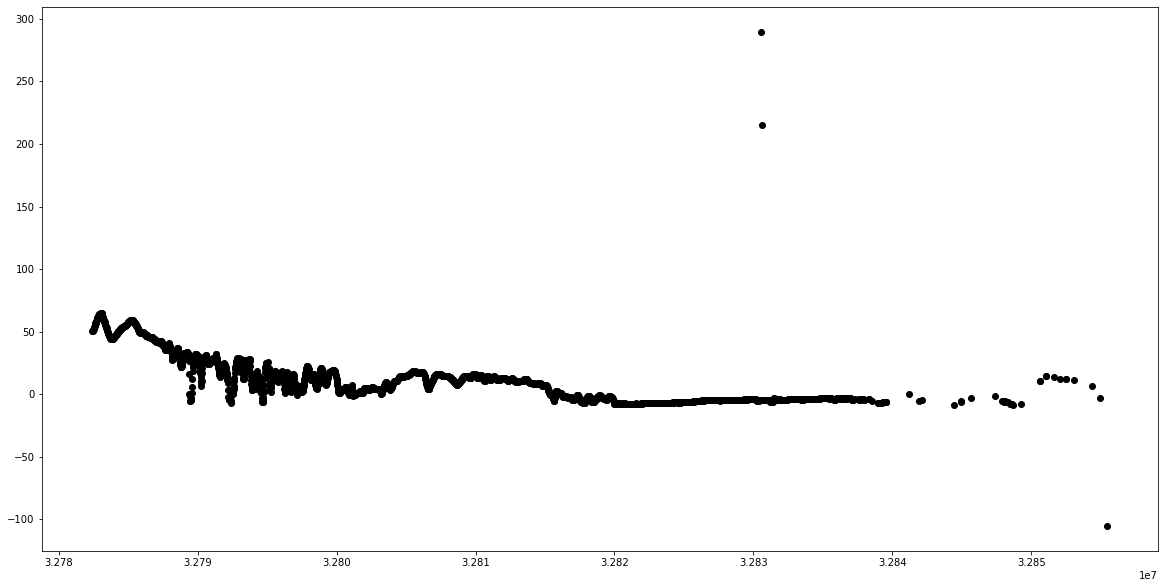

In [261]:
#access a different track and date
atl06_1322 = atl06_sr[(atl06_sr.index.date==datetime.date(2021, 6, 19))&(atl06_sr.spot == 1)]

fig,ax = plt.subplots(1,1,figsize=(20,10))

ax.scatter(atl06_1322['distance'],atl06_1322['h_mean'],c = 'k')

#plt.ylim([-50,200])

plt.show()

Roughness =  695.1155063694542


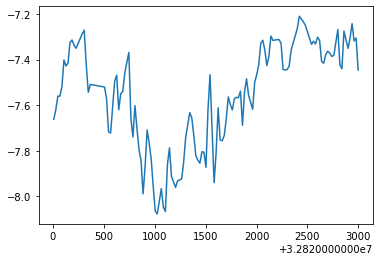

In [287]:
#calculate a roughness number for a 3000 meter section of an elevation plot
#define distance bounds
d = atl06_1322['distance'].values
d = d[(d > 3.2820e7) & (d < 3.2823e7)]
h = atl06_1322['h_mean'].values[(atl06_1322['distance'].values < 3.2823e7) & (atl06_1322['distance'].values > 3.2820e7)]

#plot elevation profile of section
plt.plot(d,h)

#remove anomolously high h values
h[h > 100] = -5

#fft for heights
yf = rfft(h)
diffs = np.diff(d)
sample_space = np.mean(diffs)
n = len(d)
xf = fftfreq(n, sample_space)[:n//2]

# get psd (power spectral density) for shelf
power = np.square(abs(yf[:n//2]))
psd = power/(xf[1]-xf[0])

#calculate roughness for all wave numbers
int_psd = integrate.cumulative_trapezoid(psd,xf)
R = np.sqrt(int_psd)

#calculate roughness for a bounded set of wave numbers
xf_thresh = 1/3000
int_psd_subset = integrate.cumulative_trapezoid(psd[xf > xf_thresh],xf[xf > xf_thresh])
R2 = np.sqrt(int_psd_subset)

print('Roughness = ', np.max(R))

/tmp/ipykernel_2655923/2392434608.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ax[2].loglog(1/xf[:n//2], psd, '-g')


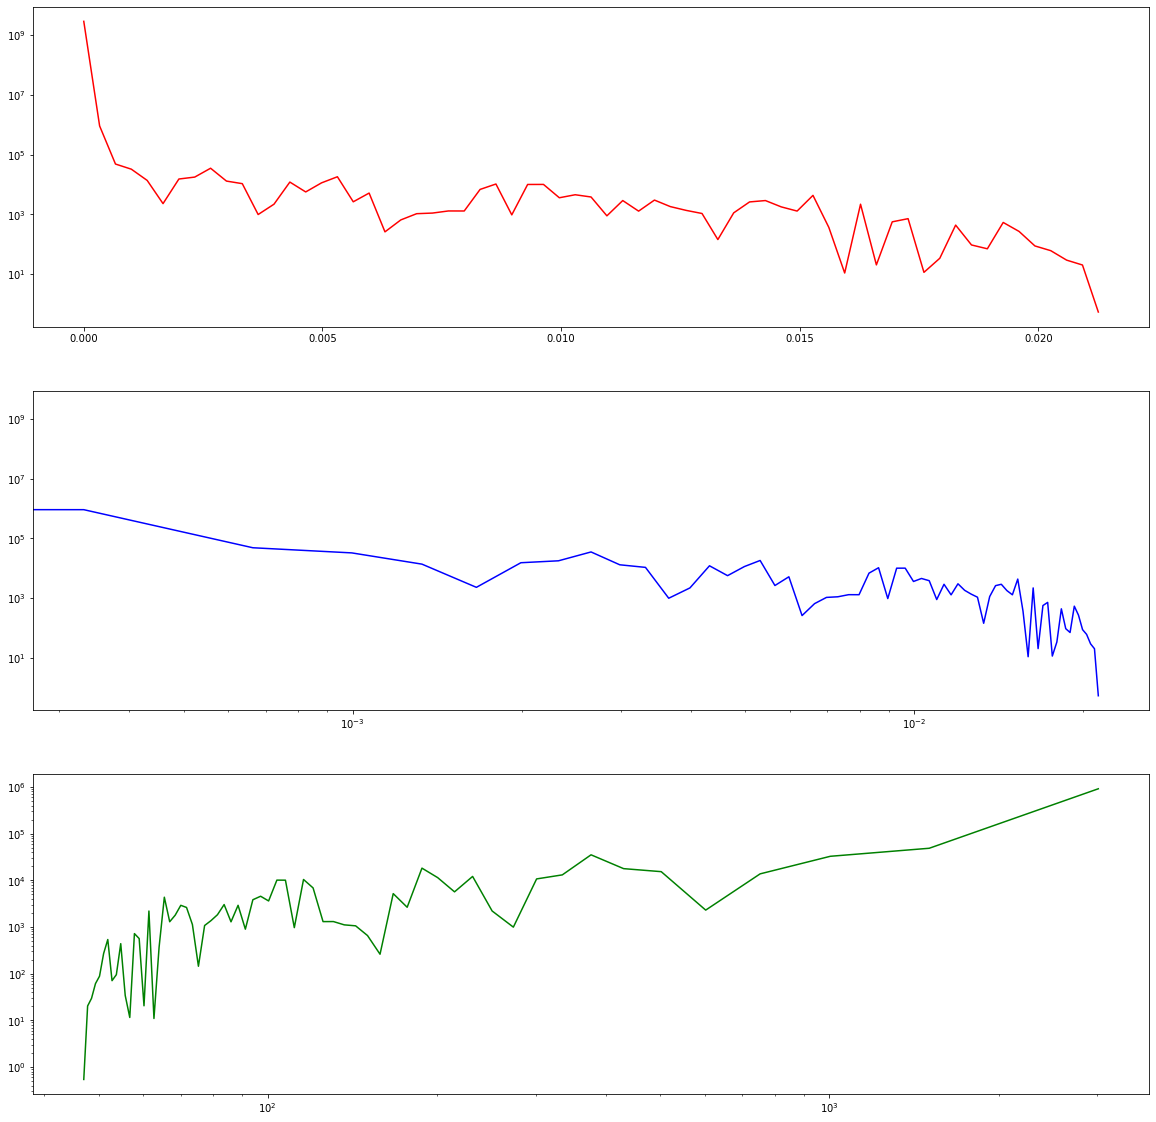

In [280]:
#compare psd plots
fig,ax = plt.subplots(3,1,figsize=(20,20))

#logarithmic y-axis, wave number on x-axis
ax[0].semilogy(xf[:n//2], psd, '-r')

#logarithmic x and y axes, wave number on x-axis
ax[1].loglog(xf[:n//2], psd, '-b')

#logarithmic x and y axes, wavelength on x-axis
ax[2].loglog(1/xf[:n//2], psd, '-g')